# Compare predictions
This notebook includes a comparison between the predictions of the hydroestimator, the cnn and the mlp on the rain gauge data.

In [291]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap
from matplotlib import cm
import copy
import torch
import xarray as xr
import pandas as pd
import os
import datetime

import cartopy
import cartopy.crs as ccrs
from pyresample import load_area, geometry

import quantnn

import sys
sys.path.append('../visualize')
import plotTestSetup as setup
from plotTest import plotFalse, plotError, plotDistribution, hist2D, ROC, ROC2, diffRatio 
import plot_dataset_funs
from plot_dataset_funs import initial_load

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Settings 

In [41]:
#data path
f = open('../path_to_data.txt', "r")
path_to_dataset = os.path.join(f.readline().rstrip("\n"))
f.close() 

In [3]:
#load dataset
combined_all = xr.open_dataset(os.path.join(path_to_dataset,'combined.nc'))
combined_all

<xarray.Dataset>
Dimensions:                  (location: 609, time: 738)
Coordinates:
  * location                 (location) int64 0 1 2 3 4 ... 604 605 606 607 608
  * time                     (time) datetime64[ns] 2020-12-01T01:00:00 ... 20...
Data variables:
    xception_posterior_mean  (time, location) float32 ...
    xception_Q0.95           (time, location) float32 ...
    xception_Q0.99           (time, location) float32 ...
    mlp_posterior_mean       (time, location) float32 ...
    mlp_Q0.95                (time, location) float32 ...
    mlp_Q0.99                (time, location) float32 ...
    HE_precip                (time, location) float64 ...
    HE_precip_corr           (time, location) float64 ...
    gauge_precip             (time, location) float64 ...

### Metadata

In [4]:
#load metadata
metadata = pd.read_pickle(os.path.join(path_to_dataset, 'real_rain_gauge_data', 'general_rain_gauge_info.pckl'))

In [5]:
#metadata[(metadata.lon< -43.2) & (metadata.lat< 22.5) & (metadata.state=='RJ')] #429

### NaNs

In [6]:
print('NaNs in gauges:', np.isnan(combined_all.gauge_precip.values).sum())
print('NaNs in HE:', np.isnan(combined_all.HE_precip.values).sum())
print('NaNs in HE corr:', np.isnan(combined_all.HE_precip_corr.values).sum())
print('NaNs in MLP:', np.isnan(combined_all.mlp_posterior_mean.values).sum())
print('NaNs in CNN:', np.isnan(combined_all.xception_posterior_mean.values).sum())

NaNs in gauges: 165555
NaNs in HE: 6090
NaNs in HE corr: 6090
NaNs in MLP: 1759
NaNs in CNN: 1759


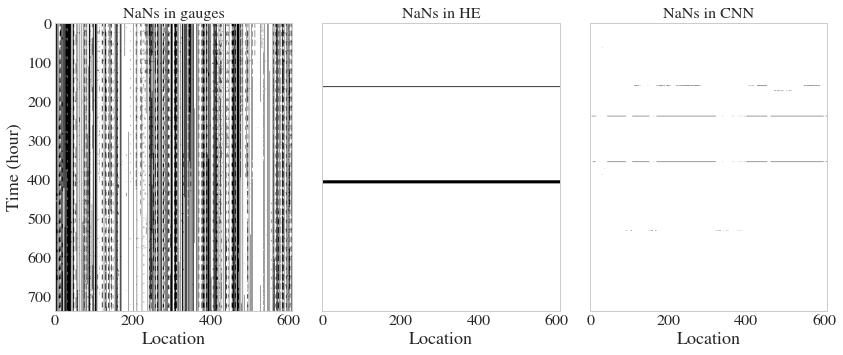

In [7]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=setup.figsize_two_cols)
data = combined_all.gauge_precip.values
m = np.zeros((data.shape[0], data.shape[1]))
m[np.isnan(data)] = 1
ax[0].imshow(m, cmap='binary')
ax[0].set_xlabel('Location')
ax[0].set_ylabel('Time (hour)')
ax[0].set_title('NaNs in gauges')
ax[0].grid(False)

data = combined_all.HE_precip.values
m = np.zeros((data.shape[0], data.shape[1]))
m[np.isnan(data)] = 1
ax[1].imshow(m, cmap='binary')
ax[1].set_xlabel('Location')
ax[1].set_title('NaNs in HE')
ax[1].grid(False)

data = combined_all.xception_posterior_mean.values
m = np.zeros((data.shape[0], data.shape[1]))
m[np.isnan(data)] = 1
ax[2].imshow(m, cmap='binary')
ax[2].set_xlabel('Location')
ax[2].set_title('NaNs in CNN')
ax[2].grid(False)

plt.tight_layout()

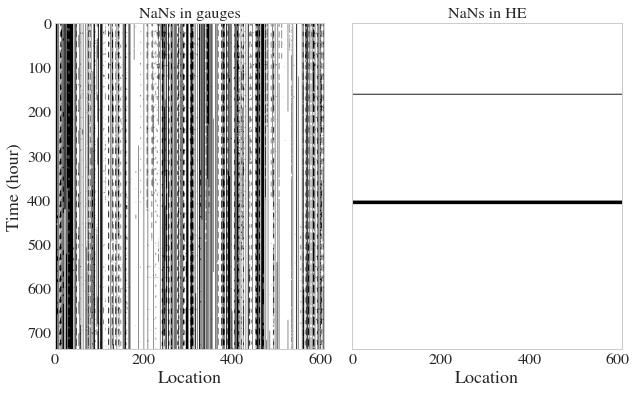

In [8]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=setup.figsize_two_cols)
data = combined_all.gauge_precip.values
m = np.zeros((data.shape[0], data.shape[1]))
m[np.isnan(data)] = 1
ax[0].imshow(m, cmap='binary')
ax[0].set_xlabel('Location')
ax[0].set_ylabel('Time (hour)')
ax[0].set_title('NaNs in gauges')
ax[0].grid(False)

data = combined_all.HE_precip.values
m = np.zeros((data.shape[0], data.shape[1]))
m[np.isnan(data)] = 1
#data = combined_all.xception_posterior_mean.values
#m[np.isnan(data)] = 1
ax[1].imshow(m, cmap='binary')
ax[1].set_xlabel('Location')
ax[1].set_title('NaNs in HE')
ax[1].grid(False)

plt.subplots_adjust(wspace=-0.2, hspace=0)
#plt.tight_layout()
#plt.savefig('../plots/thesis/missing_values.pdf', bbox_inches='tight')

In [9]:
mask = np.zeros((combined_all.gauge_precip.values.shape[0], combined_all.gauge_precip.values.shape[1]))
mask[np.isnan(combined_all.gauge_precip.values)] = 1
mask[np.isnan(combined_all.HE_precip.values)] = 1
mask[np.isnan(combined_all.xception_posterior_mean.values)] = 1

print('missing values fraction:', mask.sum()/len(mask.flatten()))

missing values fraction: 0.3793793192447524


In [10]:
# Make sure that comparison is done only where values are present in all datasets.
combined = combined_all.copy()
combined = combined.where(mask==0)

### Gauges

In [11]:
#Explore properties of reference data
dat = combined.gauge_precip.values[mask==0].flatten()
print('unique values in gauge data:', np.unique(dat))
start = -0.1
end = 83.3
binsize = 0.2
num_of_bins = int(np.round((end-start)/binsize)+1)
bins = np.linspace(start,end,num_of_bins)
#print('matching bins:', bins)

unique values in gauge data: [ 0.   0.2  0.4  0.6  0.8  1.   1.2  1.4  1.6  1.8  2.   2.2  2.4  2.6
  2.8  3.   3.2  3.4  3.6  3.8  4.   4.2  4.4  4.6  4.8  5.   5.2  5.4
  5.6  5.8  6.   6.2  6.4  6.6  6.8  7.   7.2  7.4  7.6  7.8  8.   8.2
  8.4  8.6  8.8  9.   9.2  9.4  9.6  9.8 10.  10.2 10.4 10.6 10.8 11.
 11.2 11.4 11.6 11.8 12.  12.2 12.4 12.6 12.8 13.  13.2 13.4 13.6 13.8
 14.  14.2 14.4 14.6 14.8 15.  15.2 15.4 15.6 15.8 16.  16.2 16.4 16.6
 16.8 17.  17.2 17.4 17.6 17.8 18.  18.2 18.4 18.6 18.8 19.  19.2 19.4
 19.6 19.8 20.  20.2 20.4 20.6 20.8 21.  21.2 21.4 21.6 21.8 22.  22.2
 22.4 22.6 22.8 23.  23.2 23.4 23.6 23.8 24.  24.2 24.4 24.6 24.8 25.
 25.2 25.4 25.6 25.8 26.  26.2 26.4 26.6 26.8 27.  27.2 27.4 27.6 27.8
 28.  28.2 28.4 28.6 28.8 29.  29.2 29.4 29.6 29.8 30.  30.2 30.4 30.6
 30.8 31.  31.4 31.6 32.  32.2 32.4 32.6 33.2 33.6 33.8 34.  34.4 34.6
 34.8 35.  35.2 35.4 35.6 35.8 36.  36.2 36.4 36.6 36.8 37.  37.2 37.6
 38.4 38.6 38.8 39.  39.2 39.6 39.8 40.2 40.4 40.6

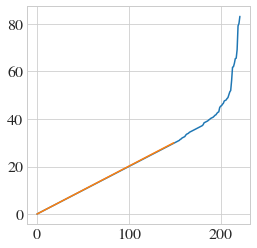

In [12]:
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(np.unique(dat))
#plt.yscale('log')
ax.plot([0,149], [0,30])

### HE

unique values in gauge data: [0.00000000e+00 1.66666667e-02 2.00000000e-02 ... 4.09000000e+01
 4.70666667e+01 4.91000000e+01]


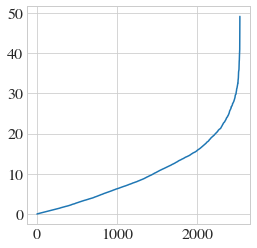

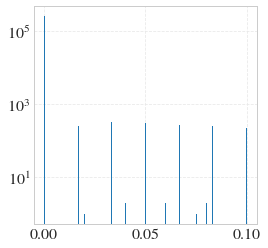

In [405]:
dat = combined.HE_precip.values[mask==0].flatten()
print('unique values in gauge data:', np.unique(dat))
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(np.unique(dat))

b = np.linspace(0.0, 0.1, 200)
fig, ax = plt.subplots(figsize=(4,4))
ax.hist(dat, bins=b)
ax.set_yscale("log")
ax.grid(True,which="both",ls="--",c=setup.color_grid)

### HE corr

unique values in gauge data: [0.00000000e+00 4.84166667e-02 5.81000000e-02 ... 3.63790000e+01
 4.24810417e+01 5.08737500e+01]


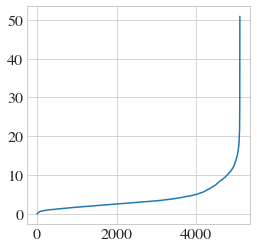

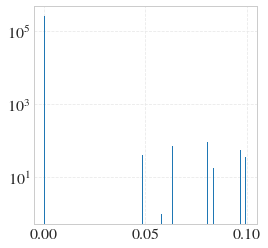

In [406]:
dat = combined.HE_precip_corr.values[mask==0].flatten()
print('unique values in gauge data:', np.unique(dat))
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(np.unique(dat))

b = np.linspace(0.0, 0.1, 200)
fig, ax = plt.subplots(figsize=(4,4))
ax.hist(dat, bins=b)
ax.set_yscale("log")
ax.grid(True,which="both",ls="--",c=setup.color_grid)

### xception

unique values in gauge data: [1.0003260e-03 1.0007619e-03 1.0010556e-03 ... 2.5899418e+01 2.7340502e+01
 3.1411234e+01]


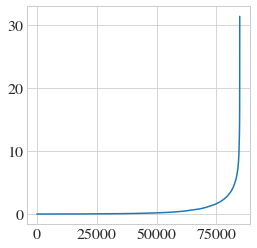

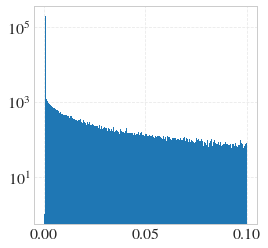

In [408]:
dat = combined.xception_posterior_mean.values[mask==0].flatten()
print('unique values in gauge data:', np.unique(dat)[np.unique(dat)>1e-3])
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(np.unique(dat))

b = np.linspace(0.0, 0.1, 200)
fig, ax = plt.subplots(figsize=(4,4))
ax.hist(dat, bins=b)
ax.set_yscale("log")
ax.grid(True,which="both",ls="--",c=setup.color_grid)

### Scalar metrics

In [13]:
def Bias(a,b,dataset,mask):
    bias = np.mean(np.subtract(dataset[b].values, dataset[a].values)[mask==0])
    return(bias)

def MAE(a,b,dataset,mask):
    mae = np.mean(np.abs(np.subtract(dataset[b].values, dataset[a].values)[mask==0]))
    return(mae)

def MSE(a,b,dataset,mask):
    mse = np.mean(np.square(np.subtract(dataset[b].values, dataset[a].values)[mask==0]))
    return(mse)

#### Bias

In [14]:
print('HE:',Bias('gauge_precip','HE_precip',combined,mask))
print('HE corr:',Bias('gauge_precip','HE_precip_corr',combined,mask))
print('MLP:',Bias('gauge_precip','mlp_posterior_mean',combined,mask))
print('CNN:',Bias('gauge_precip','xception_posterior_mean',combined,mask))

HE: 0.1041845413295188
HE corr: -0.006546504557844834
MLP: -0.02128214204459453
CNN: 0.004233128358052377


#### MAE

In [15]:
print('HE:',MAE('gauge_precip','HE_precip',combined,mask))
print('HE corr:',MAE('gauge_precip','HE_precip_corr',combined,mask))
print('MLP:',MAE('gauge_precip','mlp_posterior_mean',combined,mask))
print('CNN:',MAE('gauge_precip','xception_posterior_mean',combined,mask))

HE: 0.39354618014600884
HE corr: 0.3000981773968421
MLP: 0.26460390683247
CNN: 0.23152983903431412


#### MSE

In [16]:
print('HE:',MSE('gauge_precip','HE_precip',combined,mask))
print('HE corr:',MSE('gauge_precip','HE_precip_corr',combined,mask))
print('MLP:',MSE('gauge_precip','mlp_posterior_mean',combined,mask))
print('CNN:',MSE('gauge_precip','xception_posterior_mean',combined,mask))

HE: 3.9399494848424386
HE corr: 2.4381287135261074
MLP: 2.03985636993056
CNN: 1.698436812975142


In [17]:
def metric_by_gauge(a):
    mean_precip = combined['gauge_precip'].mean(dim='time')
    bias_precip = (combined[a] - combined['gauge_precip']).mean(dim='time')
    rel_bias_precip = bias_precip/mean_precip
    #print(rel_bias_precip)
    rel_bias_precip[rel_bias_precip==np.inf] = np.nan
    return(rel_bias_precip)

In [18]:
CG0 = metric_by_gauge('HE_precip_corr') 
CG1 = metric_by_gauge('xception_posterior_mean')

In [19]:
vmax = 100#max(np.nanmax(CG0.values), np.nanmax(CG1.values))
vmin = min(np.nanmin(CG0.values), np.nanmin(CG1.values))
cmap=plt.get_cmap('viridis_r')#plt.get_cmap('coolwarm')
cmap.set_bad('lightgrey',1.)

<ipython-input-19-ca133c822f70>:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis_r"))
  cmap.set_bad('lightgrey',1.)


/export/home/ingrid/anaconda3/envs/geo/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/export/home/ingrid/anaconda3/envs/geo/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


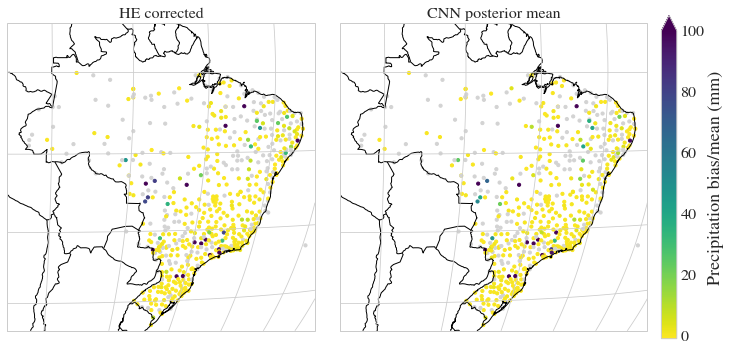

In [20]:
areas_filepath =  '../dataset/downloads/files/areas.yaml'
initial_load(areas_filepath)
area_def_region = plot_dataset_funs.area_def.copy(area_extent = plot_dataset_funs.region_corners,
                                                  height = plot_dataset_funs.region_height, 
                                                  width = plot_dataset_funs.region_width)
crs = area_def_region.to_cartopy_crs()
fig, ax = plt.subplots(1,2, subplot_kw={'projection': crs}, figsize = setup.figsize_two_cols)

m = ax[0].scatter(x=metadata.lon, y=metadata.lat, c=CG0, transform=ccrs.PlateCarree(), s=10, cmap=cmap, 
                  vmax=vmax, vmin=vmin)

ax[0].coastlines()
ax[0].gridlines()
ax[0].add_feature(cartopy.feature.BORDERS)
ax[0].set_global()
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title(setup.variable_dict['HE_precip_corr']['label'])

m = ax[1].scatter(x=metadata.lon, y=metadata.lat, c=CG1, transform=ccrs.PlateCarree(), s=10, cmap=cmap, 
                  vmax=vmax, vmin=vmin)

ax[1].coastlines()
ax[1].gridlines()
ax[1].add_feature(cartopy.feature.BORDERS)
ax[1].set_global()
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_title(setup.variable_dict['xception_posterior_mean']['label'])


fig.subplots_adjust(wspace=0.08)
fig.colorbar(m, ax=ax, fraction=0.023, pad=0.021, extend='max').set_label(label='Precipitation bias/mean (mm)', size=18)
#plt.savefig('../plots/thesis/gaugesbiasdmean.pdf', bbox_inches='tight')

In [21]:
CGt = combined['gauge_precip'].mean(dim='time')

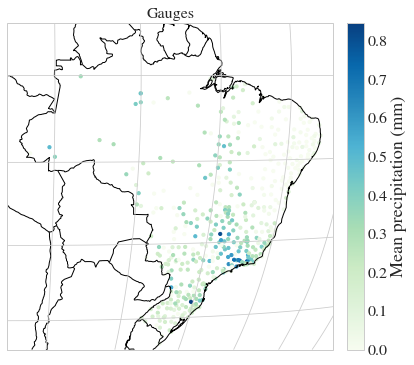

In [22]:
fig, ax = plt.subplots(subplot_kw={'projection': crs}, figsize = setup.figsize_two_cols)

m = ax.scatter(x=metadata.lon, y=metadata.lat, c=CGt, transform=ccrs.PlateCarree(), s=10, #1/CGt
               cmap=plt.get_cmap('GnBu'))#, vmax=1500)

ax.coastlines()
ax.gridlines()
ax.add_feature(cartopy.feature.BORDERS)
ax.set_global()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title(setup.variable_dict['gauge_precip']['label'])
fig.subplots_adjust(wspace=0.08)
fig.colorbar(m, ax=ax, fraction=0.025, pad=0.021).set_label(label='Mean precipitation (mm)', size=18) #extend='max'
#plt.savefig('../plots/thesis/gaugesmean.pdf', bbox_inches='tight') #inv

### Histograms 

In [23]:
#Extract for plotting
data_dict = {}
quantity = 'precipitation (mm)'
data_list = ['gauge_precip', 'HE_precip', 'HE_precip_corr', 'mlp_posterior_mean', 'xception_posterior_mean']
for var in data_list:
    data_dict[var] = combined[var].values[mask==0].flatten()

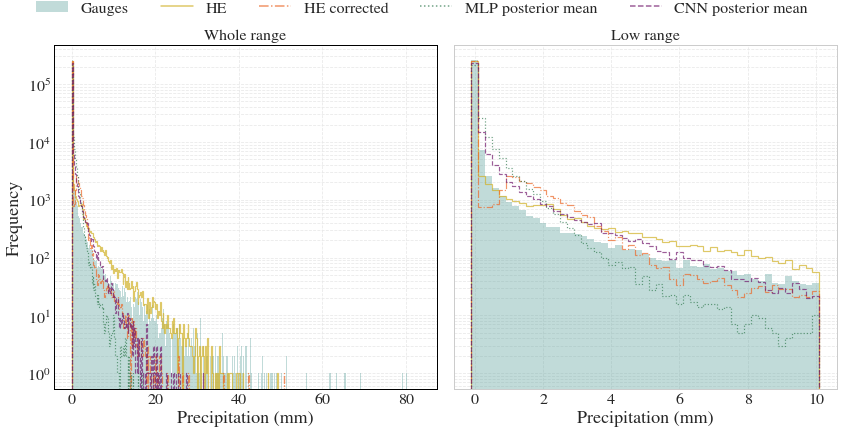

In [24]:
var_list = ['HE_precip', 'HE_precip_corr', 'mlp_posterior_mean', 'xception_posterior_mean']
plotDistribution(data_dict, bins, 'gauge_precip', 
                 ['HE_precip', 'HE_precip_corr', 'mlp_posterior_mean', 'xception_posterior_mean'],
                quantity=quantity, linestyles=['solid', 'dashdot', 'dotted', 'dashed'], 
                 #filename='../plots/thesis/pdf_gauge.pdf'
                )

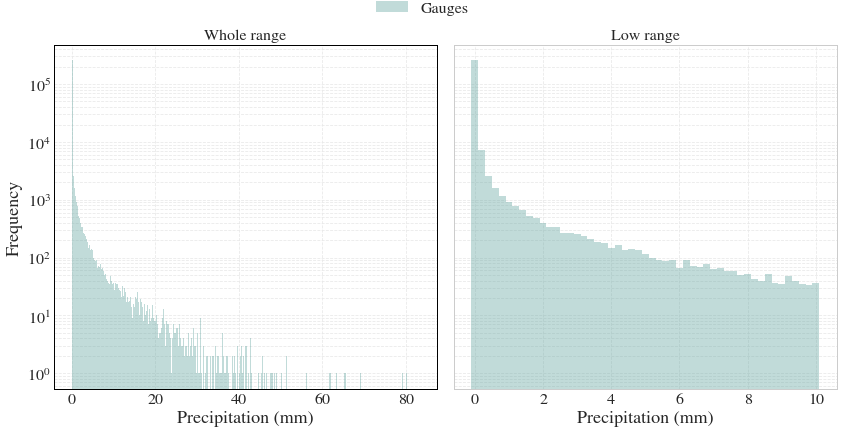

In [25]:
plotDistribution(data_dict, bins, 'gauge_precip', 
                 [],
                quantity=quantity,
                #filename='../plots/thesis/pdf_gauge.pdf'
                )

### Error

In [292]:
var_list = ['HE_precip', 'HE_precip_corr','xception_posterior_mean']
diffRatio(data_dict, 'gauge_precip', var_list, -0.1, 0.1)

[0.8663621729949486, 0.862483105261837, 0.8287975965554452]

In [117]:
start_diff = -83.1 #np.floor(np.min([np.min(diff_HE_corr), np.min(diff_CNN)]))
print(start_diff)
end_diff = 51.1 #np.ceil(np.max([np.max(diff_HE_corr), np.max(diff_CNN)]))
print(end_diff)
binsize_diff = 0.2
diffbins = np.linspace(start_diff,end_diff,int(np.round((end_diff-start_diff)/binsize_diff))+1)
#print(diffbins)

-83.1
51.1


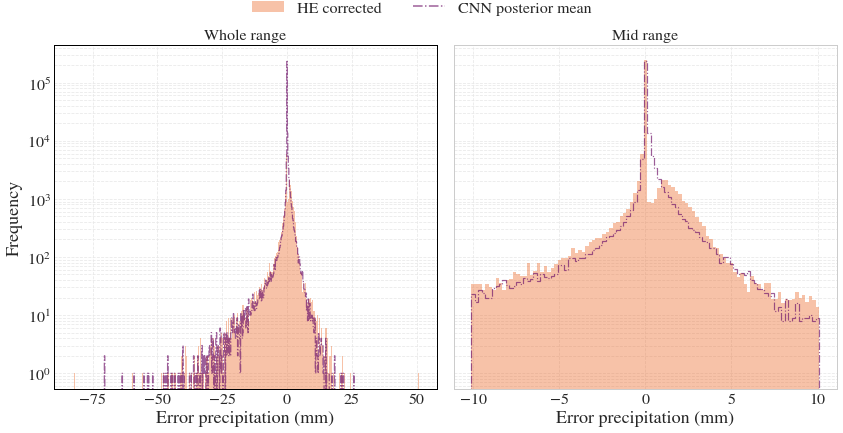

In [118]:
var_list = [
            #'HE_precip', 
            'HE_precip_corr',
            #'mlp_posterior_mean', 
            'xception_posterior_mean'
]
plotError(data_dict, diffbins, 'gauge_precip', var_list, quantity=quantity,
          linestyles=['solid', 'dashdot', 'dotted', 'dashed']
          #,filename='../plots/thesis/diff_gauge_app.pdf'
          #,filename='../plots/thesis/diff_gauge.pdf'         
         )

### Classes

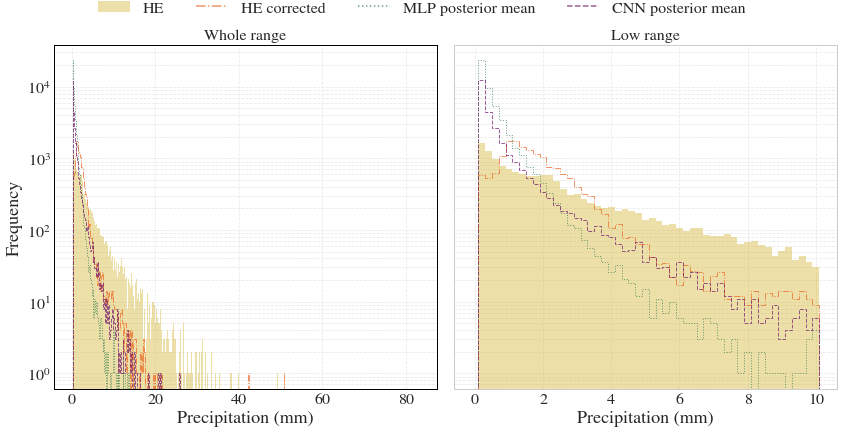

In [53]:
plotFalse(data_dict, bins, 'gauge_precip', 
                 ['HE_precip', 'HE_precip_corr', 'mlp_posterior_mean', 'xception_posterior_mean'],
          ty='FP', quantity=quantity,
          linestyles=['solid', 'dashdot', 'dotted', 'dashed']
          #,filename="../plots/thesis/FalsePositives_gauge.pdf"
          #,filename="../plots/thesis/FalsePositives_gauge_app.pdf"
                )

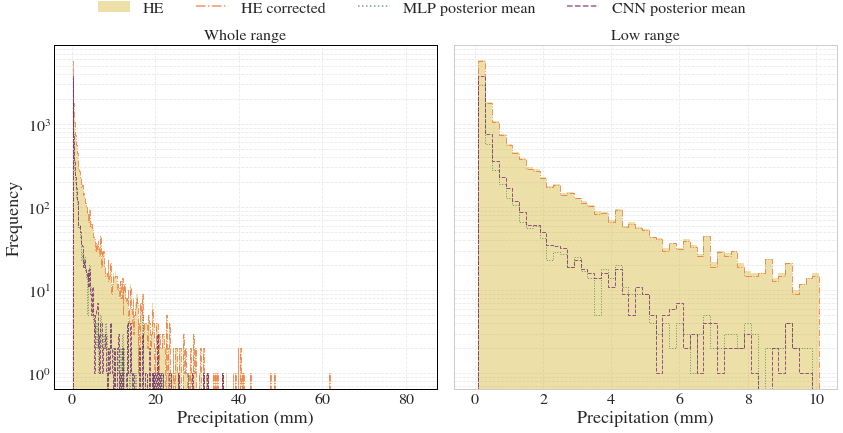

In [59]:
plotFalse(data_dict, bins, 'gauge_precip', 
                 ['HE_precip', 'HE_precip_corr', 'mlp_posterior_mean', 'xception_posterior_mean'],
          ty='FN', quantity=quantity,
          linestyles=['solid', 'dashdot', 'dotted', 'dashed']
          #,filename="../plots/thesis/FalseNegatives_gauge.pdf"
          #,filename="../plots/thesis/FalseNegatives_gauge_app.pdf"
                )

In [ ]:
def Classification(y,p, threshold=1e-1):

    TP = (p[y>threshold]>threshold).sum() #Is rain, predict rain
    TN = (p[y<=threshold]<=threshold).sum() #Is no rain, predict no rain
    FP = (p[y<=threshold]>threshold).sum() #Is no rain, predict rain
    FN = (p[y>threshold]<=threshold).sum() #Is rain, predict no rain

    #'''
    fig, ax = plt.subplots()
    confusion_matrix = np.array([[FP, TP], [TN, FN]])#np.array([[TP, FN], [FP, TN]])
    m = ax.imshow(confusion_matrix, cmap='Greens')
    ax.set_ylabel('Predicted class')
    ax.set_xlabel('True class')
    ax.grid(False)
    ax.set_xticks(ticks=[0,1])
    ax.set_xticklabels(labels=['No rain', 'Rain',])
    ax.set_yticks(ticks=[1,0])
    ax.set_yticklabels(labels=['No rain', 'Rain'])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.07)
    plt.colorbar(m, cax=cax)
    
    # Loop over data dimensions and create text annotations.
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            text = ax.text(j, i, confusion_matrix[i, j],
                           ha="center", va="center", color="orange", fontsize=18)
    plt.show()
    #'''
    
    #print('TP, Is rain, predict rain:', TP)
    #print('TN, Is no rain, predict no rain:', TN)
    #print('FP, Is no rain, predict rain:', FP)
    #print('FN, Is rain, predict no rain:', FN)

    TPR = (TP/(TP+FN)) #Sensitivity or Recall (POD=hits/(hits+misses))
    #print('TPR', "{:.2f}".format(TPR))
    TNR = (TN/(TN+FP)) #Specificity
    #print('TPR', "{:.2f}".format(TNR))
    PPV = (TP/(TP+FP)) #Precision
    #print('PPV', "{:.2f}".format(PPV))
    PNV = (TN/(TN+FN))
    #print('PNV', "{:.2f}".format(PNV))

    FAR = (FP/(FP+FN)) #false alarms/(false alarms+hits)
    #print('FAR', "{:.2f}".format(FAR)) 

    CSI = TP/(TP+FN+FP) #hits/(hits+misses+false alarms)
    #print('CSI', "{:.2f}".format(CSI))
    
    FPR = FP/(FP+TN)
    FNR = FN/(FN+TP)
    print('FPR:', FPR)
    print('FNR:', FNR)

In [ ]:
#th=1e-1
#th=1.9e-1
th=5e-1

In [ ]:
#HE 
Classification(combined.gauge_precip.values[mask==0].flatten(),
               combined.HE_precip.values[mask==0].flatten(),  threshold=th)

In [ ]:
#HE corrected
Classification(combined.gauge_precip.values[mask==0].flatten(),
               combined.HE_precip_corr.values[mask==0].flatten(),  threshold=th)

In [ ]:
#MLP
Classification(combined.gauge_precip.values[mask==0].flatten(),
               combined.mlp_posterior_mean.values[mask==0].flatten(),  threshold=th)

In [ ]:
#CNN
Classification(combined.gauge_precip.values[mask==0].flatten(),
               combined.xception_posterior_mean.values[mask==0].flatten(), threshold=th)

In [ ]:
def ClassificationV2(y,p):
    #Classes:
    # c0: no rain (<0.1 mm)
    # c1: <1.0 mm
    # c2: <5.0 mm
    # c3: <10.0 mm
    y_th = (y>2e-1)
    y = y[y_th]
    p = p[y_th]
    
    
    
    #confusion_thresholds = np.array([-1.0, 0.1, 1.0, 5.0, 10.0, 500.0])
    #confusion_thresholds = np.array([0.0, 0.2, 1.0, 10.0, 500.0])
    q = np.linspace(0.01,1,15)
    print(q)
    confusion_thresholds = np.quantile(y, q)
    print(confusion_thresholds)
    confusion_matrix = np.zeros((len(confusion_thresholds)-1,len(confusion_thresholds)-1))
    
    y_classes = np.zeros(y.shape)
    p_classes = np.zeros(p.shape)
    for i in range(len(confusion_thresholds)-1):
        y_mask = ((y>confusion_thresholds[i]) & (y<=confusion_thresholds[i+1]))
        y_classes[y_mask] = i
        p_mask = ((p>confusion_thresholds[i]) & (p<=confusion_thresholds[i+1]))
        p_classes[p_mask] = i
    
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            #print((y_classes==i).sum())
            confusion_matrix[i,j] = (p_classes[y_classes==i]==j).sum()/(y_classes==i).sum()
            
            
    fig, ax = plt.subplots(figsize=(8,8))
    m = ax.imshow(confusion_matrix, cmap='Greens')
    ax.set_ylabel('Predicted class')
    ax.set_xlabel('True class')
    ax.grid(False)
    #ax.set_xticks(ticks=[0,1])
    #ax.set_xticklabels(labels=['No rain', 'Rain',])
    #ax.set_yticks(ticks=[1,0])
    #ax.set_yticklabels(labels=['No rain', 'Rain'])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.07)
    plt.colorbar(m, cax=cax)
    
    # Loop over data dimensions and create text annotations.
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            text = ax.text(j, i, round(confusion_matrix[i, j], 2),
                           ha="center", va="center", color="orange", fontsize=18)
    plt.show()
    
    plt.hist(y_classes)

0.10024080267558529


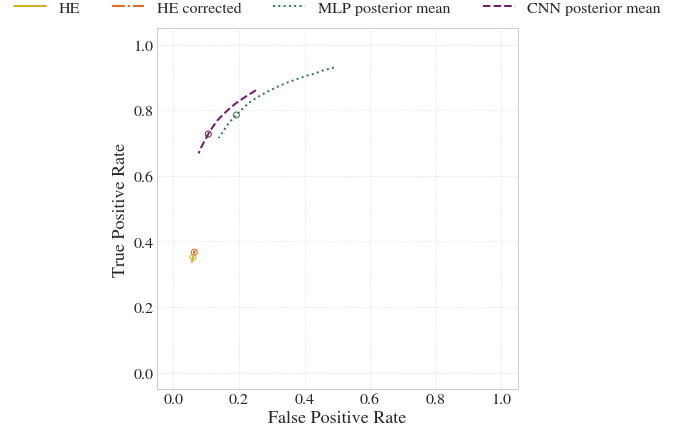

In [290]:
ROC(data_dict, 'gauge_precip', ['HE_precip', 'HE_precip_corr',
                                'mlp_posterior_mean', 'xception_posterior_mean'],
   lims=[1e-3,0.19],nums=300,
     linestyles=['solid', 'dashdot', 'dotted', 'dashed']
    #,filename='../plots/thesis/ROC.pdf'
   )

In [359]:
#ths = np.sort(np.concatenate([np.array([-0.0001, 0.0]), np.logspace(1e-4,1e-2, 200), np.linspace(1e-2,1e0,200), np.linspace(1e0,100,200)]))
ths = np.concatenate([np.array([-1e-6]), np.linspace(0.0, 1e-2, 800), np.linspace(1e-2, 5e-1, 400), np.linspace(5e-1, 20, 200)])
#ths = np.linspace(-1e-6, 20, 1400)

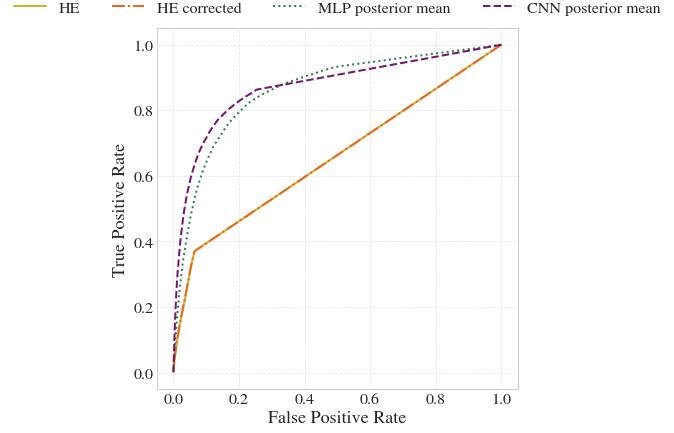

In [364]:
ROC2(data_dict, 'gauge_precip', ['HE_precip', 'HE_precip_corr',
                                'mlp_posterior_mean', 'xception_posterior_mean'],
    thresholds=ths,
     scatter_ths = [],#[1e-3, 0.19],
     t_fix = 0.1,
     linestyles=['solid', 'dashdot', 'dotted', 'dashed']
    #,filename='../plots/thesis/ROC2.pdf'
   )

In [ ]:
data_dict['gauge_precip']

In [ ]:
bins = np.linspace(-0.1,83.9, 421)

In [439]:
np.linspace(-0.1,83.9, 211)

array([-0.1,  0.3,  0.7,  1.1,  1.5,  1.9,  2.3,  2.7,  3.1,  3.5,  3.9,
        4.3,  4.7,  5.1,  5.5,  5.9,  6.3,  6.7,  7.1,  7.5,  7.9,  8.3,
        8.7,  9.1,  9.5,  9.9, 10.3, 10.7, 11.1, 11.5, 11.9, 12.3, 12.7,
       13.1, 13.5, 13.9, 14.3, 14.7, 15.1, 15.5, 15.9, 16.3, 16.7, 17.1,
       17.5, 17.9, 18.3, 18.7, 19.1, 19.5, 19.9, 20.3, 20.7, 21.1, 21.5,
       21.9, 22.3, 22.7, 23.1, 23.5, 23.9, 24.3, 24.7, 25.1, 25.5, 25.9,
       26.3, 26.7, 27.1, 27.5, 27.9, 28.3, 28.7, 29.1, 29.5, 29.9, 30.3,
       30.7, 31.1, 31.5, 31.9, 32.3, 32.7, 33.1, 33.5, 33.9, 34.3, 34.7,
       35.1, 35.5, 35.9, 36.3, 36.7, 37.1, 37.5, 37.9, 38.3, 38.7, 39.1,
       39.5, 39.9, 40.3, 40.7, 41.1, 41.5, 41.9, 42.3, 42.7, 43.1, 43.5,
       43.9, 44.3, 44.7, 45.1, 45.5, 45.9, 46.3, 46.7, 47.1, 47.5, 47.9,
       48.3, 48.7, 49.1, 49.5, 49.9, 50.3, 50.7, 51.1, 51.5, 51.9, 52.3,
       52.7, 53.1, 53.5, 53.9, 54.3, 54.7, 55.1, 55.5, 55.9, 56.3, 56.7,
       57.1, 57.5, 57.9, 58.3, 58.7, 59.1, 59.5, 59

In [436]:
(83.9+0.1)/0.4

210.0

### 2D histograms

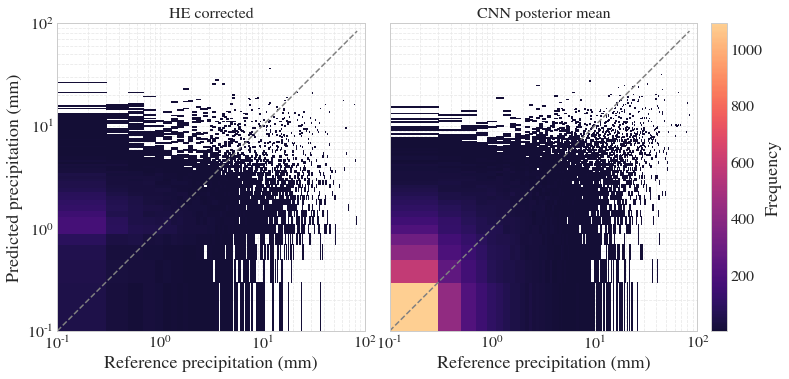

In [452]:
hist2D(data_dict, 'gauge_precip', ['HE_precip_corr', 'xception_posterior_mean'], norm_type=None, quantity=quantity
      #,filename='../plots/thesis/2D_hist_gauges_nonlog.pdf'
      ,bins = np.linspace(0.1,83.9, 420) #np.linspace(-0.1,83.9, 211)
      )

0.4257142857142818
0.4257142857142818


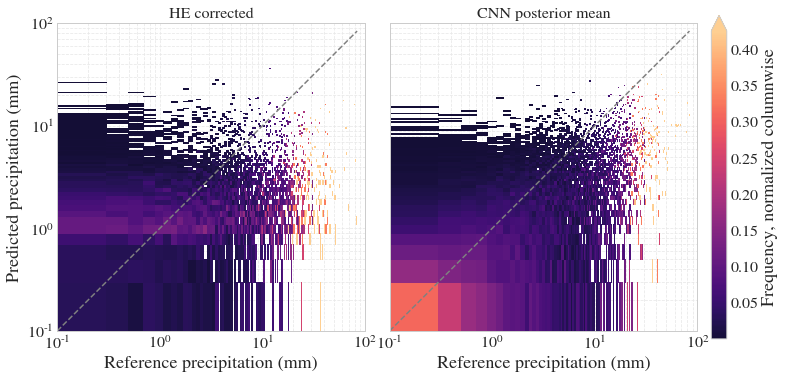

In [453]:
hist2D(data_dict, 'gauge_precip', ['HE_precip_corr', 'xception_posterior_mean'], norm_type='colwise', quantity=quantity
      #,filename='../plots/thesis/2D_hist_colwise_gauges_nonlog.pdf'
       ,bins = np.linspace(0.1,83.9, 420)#np.linspace(-0.1,83.9, 421)
      )

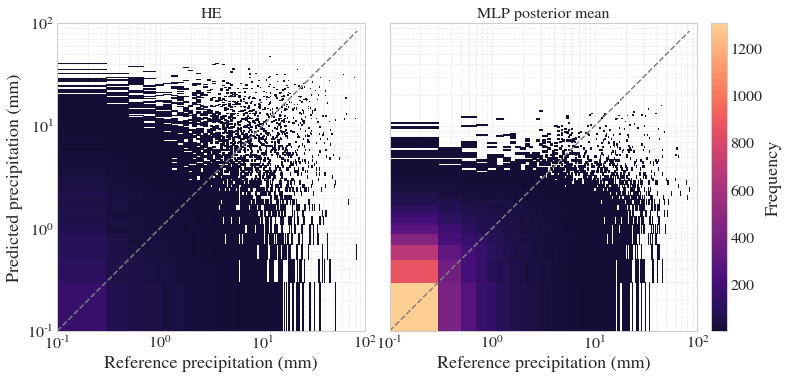

In [454]:
hist2D(data_dict, 'gauge_precip', ['HE_precip', 'mlp_posterior_mean'], norm_type=None, quantity=quantity
      #,filename='../plots/thesis/2D_hist_gauges_app_nonlog.pdf'
       , bins = np.linspace(0.1,83.9, 420)
      )

0.3333333333333333
0.4285714285714285


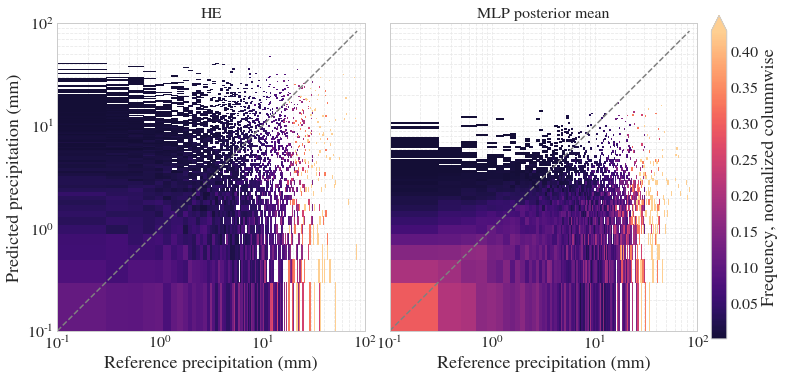

In [455]:
hist2D(data_dict, 'gauge_precip',  ['HE_precip', 'mlp_posterior_mean'], norm_type='colwise', quantity=quantity
      #,filename='../plots/thesis/2D_hist_colwise_gauges_app_nonlog.pdf'
       , bins = np.linspace(0.1,83.9, 420)
      )

### Diurnal cycle

In [66]:
import datetime
import timezonefinder, pytz

tf = timezonefinder.TimezoneFinder()

def getTimeZone(lat, lon):
    timezone_str = tf.certain_timezone_at(lat=lat, lng=lon)

    if timezone_str is None:
        print( "Could not determine the time zone")
        return(None)
    else:
        # Assuming same utc offset at given location throughout whole timeperiod Dec 2020
        timezone = pytz.timezone(timezone_str)
        dt = datetime.datetime(2020,12,1)
    return(timezone.utcoffset(dt).total_seconds()/3600.0)

In [67]:
def UTCtoLocal(dataset,mdat):
    shift = []
    for i in mdat.index:
        shift.append(getTimeZone(mdat.lat[i], mdat.lon[i]))
        
    ind_to_shift = []
    for s in np.unique(shift):
        ind_to_shift.append(list(np.where(shift==s)))
        
    di = dataset.copy()
    dj = dataset.copy()
    
    abs_diff = int(np.max(np.abs(np.unique(shift))))
    to_add = dj.time.min()+np.timedelta64(abs_diff,'h')
    
    dj = dj.where(dj.time<to_add, drop=True)
    dj = dj.where(dj.time<di.time.min())
    
    dj = dj.assign_coords(time=di.time[:abs_diff]-np.timedelta64(abs_diff,'h'))
    
    dext = xr.concat([dj, di], "time")
    
    datasets = []
    for i in range(len(np.unique(shift))):
        print(int(np.unique(shift)[i]))
        #print(ind_to_shift[i][0])
        selection = dext.copy().isel(location=ind_to_shift[i][0])
        selection = selection.shift(time=int(np.unique(shift)[i]))
        datasets.append(selection)    
        
    dshifted = xr.concat(datasets, "location")
    dshifted = dshifted.sortby("location")
    
    return(dshifted)

In [68]:
combined_local_time = UTCtoLocal(combined, metadata)

-5
-4
-3
-2


In [93]:
def diurnal_cycle(dataset, xlab='Time (hour)'):
    di = dataset.copy()
    di = di.mean(dim='location')
    di = di.groupby('time.hour')
    st = di.std()
    me = di.mean()

    fig, ax = plt.subplots(figsize=setup.figsize_single_plot)

    ax.plot(me.hour, me.gauge_precip, label=setup.variable_dict['gauge_precip']['label'], color=setup.variable_dict['gauge_precip']['color'])
    ax.plot(me.hour, me.HE_precip_corr, label=setup.variable_dict['HE_precip_corr']['label'], linestyle='dashdot', color=setup.variable_dict['HE_precip_corr']['color'])
    #ax.plot(me.hour, me.HE_precip, label=setup.variable_dict['HE_precip']['label'], linestyle='dashed', color=setup.variable_dict['HE_precip']['color'])
    ax.plot(me.hour, me.xception_posterior_mean, label=setup.variable_dict['xception_posterior_mean']['label'], linestyle='dashed', color=setup.variable_dict['xception_posterior_mean']['color'])
    #ax.plot(me.hour, me.mlp_posterior_mean, label=setup.variable_dict['mlp_posterior_mean']['label'], linestyle='dotted', color=setup.variable_dict['mlp_posterior_mean']['color'])
    ax.fill_between(me.hour, me.gauge_precip+st.gauge_precip,
                    me.gauge_precip-st.gauge_precip, linestyle='--', alpha=0.1, color=setup.variable_dict['gauge_precip']['color'])
    ax.fill_between(me.hour, me.HE_precip_corr+st.HE_precip_corr, 
                    me.HE_precip_corr-st.HE_precip_corr, alpha=0.1, color=setup.variable_dict['HE_precip_corr']['color'])
    #ax.fill_between(me.hour, me.HE_precip+st.HE_precip, 
    #                me.HE_precip-st.HE_precip, alpha=0.1, color=setup.variable_dict['HE_precip']['color'])
    ax.fill_between(me.hour, me.xception_posterior_mean+st.xception_posterior_mean,
                       me.xception_posterior_mean-st.xception_posterior_mean, alpha=0.1, color=setup.variable_dict['xception_posterior_mean']['color'])
    #ax.fill_between(me.hour, me.mlp_posterior_mean+st.mlp_posterior_mean,
    #                   me.mlp_posterior_mean-st.mlp_posterior_mean, alpha=0.1, color=setup.variable_dict['mlp_posterior_mean']['color'])
    ax.grid(True,which="both",ls="--",c=setup.color_grid)
    ax.set_ylabel(quantity.capitalize())
    ax.set_xlabel(xlab)
    ax.legend(loc='upper left')
    plt.tight_layout()
    #plt.savefig('../plots/thesis/diurnal_cycle_gauge.pdf', bbox_inches='tight')
    #plt.savefig('../plots/thesis/diurnal_cycle_gauge_app.pdf', bbox_inches='tight')

In [94]:
#diurnal_cycle(combined)

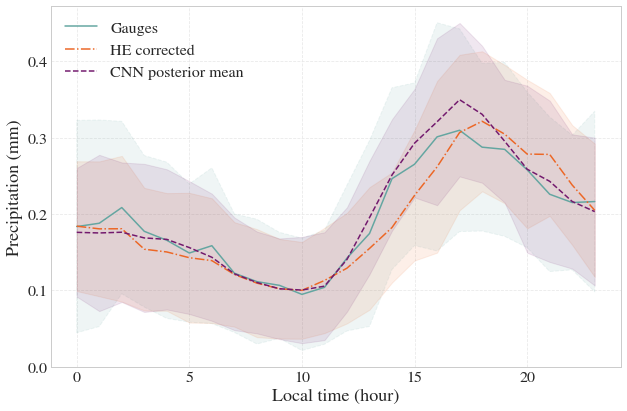

In [95]:
diurnal_cycle(combined_local_time, xlab='Local time (hour)') #time with local utc offset

In [220]:
(np.isnan(combined_local_time.HE_precip_corr) == np.isnan(combined_local_time.gauge_precip)).all()

<xarray.DataArray ()>
array(True)

In [221]:
(np.isnan(combined_local_time.xception_posterior_mean) == np.isnan(combined_local_time.gauge_precip)).all()

<xarray.DataArray ()>
array(True)

### Single rain gauge over time

In [207]:
import matplotlib.dates as mdates

def plotGaugeTimeseries(ind,start=0,end=-1):
    fig, ax = plt.subplots(figsize=(16,8))
    locator = mdates.AutoDateLocator(minticks=7, maxticks=10)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    #plt.plot(combined.time[start:end], combined.mlp_posterior_mean[start:end, ind], color=setup.variable_dict['mlp_posterior_mean']['color'], linestyle='dotted', label=setup.variable_dict['mlp_posterior_mean']['label'])
    plt.plot(combined.time[start:end], combined.HE_precip_corr[start:end, ind], label=setup.variable_dict['HE_precip_corr']['label'], linestyle='dashdot', color=setup.variable_dict['HE_precip_corr']['color'])
    plt.plot(combined.time[start:end], combined.gauge_precip[start:end, ind], label=setup.variable_dict['gauge_precip']['label'], color=setup.variable_dict['gauge_precip']['color'])
    plt.plot(combined.time[start:end], combined.xception_posterior_mean[start:end, ind], color=setup.variable_dict['xception_posterior_mean']['color'], linestyle='dashed', label=setup.variable_dict['xception_posterior_mean']['label'])
    plt.fill_between(combined.time[start:end], combined['xception_Q0.95'][start:end, ind],alpha=0.07, color=setup.variable_dict['xception_posterior_mean']['color'])
    plt.fill_between(combined.time[start:end], combined['xception_Q0.99'][start:end, ind],alpha=0.1, color=setup.variable_dict['xception_posterior_mean']['color'])
    #plt.plot(combined.time[start:end], combined.HE_precip[start:end, ind], label=setup.variable_dict['HE_precip']['label'], linestyle='dashdot', color=setup.variable_dict['HE_precip']['color'])
    ax.grid(True,which="both",ls="--",c=setup.color_grid)
    ax.set_ylabel('Precipitation (mm)')
    ax.set_xlabel('Datetime (hour)')
    ax.legend()
    #plt.gcf().autofmt_xdate()
    #plt.savefig('../plots/thesis/Xerém.pdf', bbox_inches='tight')
    #plt.savefig('../plots/thesis/'+str(ind)+'_example.pdf', bbox_inches='tight')
    
    print(sum(combined.gauge_precip[start:end, ind]))
    print(combined.time[start])
    print(combined.time[end-1])

<xarray.DataArray 'gauge_precip' ()>
array(247.6)
Coordinates:
    location  int64 429
<xarray.DataArray 'time' ()>
array('2020-12-22T01:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-12-22T01:00:00
<xarray.DataArray 'time' ()>
array('2020-12-24T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-12-24


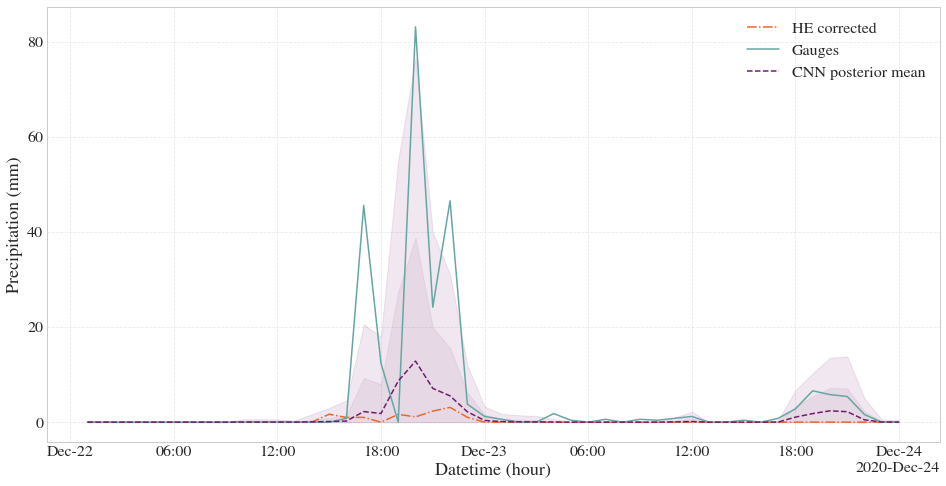

In [209]:
plotGaugeTimeseries(429,504,552) # Xerém

In [ ]:
def plotExample(interval_length=48):
    ex_gauge = np.random.randint(0,len(combined.location))
    ex_time = np.random.randint(0,len(combined.time)-interval_length)
    print(ex_gauge, ex_time)
    gauge_vals = combined.gauge_precip[ex_time:ex_time+interval_length, ex_gauge]
    if np.isnan(gauge_vals).any():
        plotExample()
    else:
        plotGaugeTimeseries(ex_gauge,ex_time,ex_time+interval_length)

In [ ]:
plotExample()

In [ ]:

ind = 429
daym = combined.copy()
daym = daym.resample(time='D').sum()
fig, ax = plt.subplots(figsize=(16,8))
#plt.plot(daym.time, daym.mlp_posterior_mean[:, ind], label='mlp')
#ax.plot(daym.time, daym.HE_precip[:, ind], label='HE', color='#e6e6e6')
ax.fill_between(daym.time, daym['xception_Q0.99'][:, ind], alpha=0.07,
                color=setup.variable_dict['xception_posterior_mean']['color'])
ax.fill_between(daym.time, daym['xception_Q0.95'][:, ind], alpha=0.05, 
                color=setup.variable_dict['xception_posterior_mean']['color'])

ax.plot(daym.time, daym.HE_precip_corr[:, ind], label=setup.variable_dict['HE_precip_corr']['label'], 
        linestyle='dashdot',
        color=setup.variable_dict['HE_precip_corr']['color'])
ax.plot(daym.time, daym.xception_posterior_mean[:, ind], 
        label=setup.variable_dict['xception_posterior_mean']['label'],
        linestyle='dashed',
        color=setup.variable_dict['xception_posterior_mean']['color'])
ax.plot(daym.time, daym.gauge_precip[:, ind], label=setup.variable_dict['gauge_precip']['label'], 
        color=setup.variable_dict['gauge_precip']['color'])

ax.grid(True,which="both",ls="--",c=setup.color_grid)
ax.set_ylabel('Precipitation (mm)')
ax.set_xlabel('Datetime (day)')
ax.set_title('Daily precipitation Xerém rain gauge Dec 2020')
ax.legend()

### By region

In [ ]:
reg = ['N', 'SE', 'CW', 'S', 'NE'] #np.unique(metadata.region)
print(reg)
mse_by_region = np.zeros((len(reg),4))

for i in range(len(reg)):
    locs = list(metadata.index[metadata.region == reg[i]])
    print(len(locs))
    selection = combined.copy().isel(location=locs)
    mse_by_region[i,0] = MSE('gauge_precip', 'HE_precip', selection, mask[:,locs])
    mse_by_region[i,1] = MSE('gauge_precip', 'HE_precip_corr', selection, mask[:,locs])
    mse_by_region[i,2] = MSE('gauge_precip', 'mlp_posterior_mean', selection, mask[:,locs])
    mse_by_region[i,3] = MSE('gauge_precip', 'xception_posterior_mean', selection, mask[:,locs])
    
fig, ax = plt.subplots(figsize=(8,8))
m = ax.imshow(mse_by_region, cmap='Greens')
ax.set_yticks(list(range(len(reg))))
ax.set_yticklabels(reg)
mods = ['HE', 'HE corr', 'MLP', 'CNN']
ax.set_xticks(list(range(len(mods))))
ax.set_xticklabels(mods)
ax.set_title('MSE by region')
ax.grid(False)
fig.colorbar(m)
plt.show()

In [ ]:
dat = combined.HE_precip_corr.values[mask==0].flatten()
print('unique values in gauge data:', np.unique(dat))
print(np.min(dat), np.max(dat))

In [ ]:
HE_bins=np.linspace(0,51,5001)
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(dat[dat>0.0], bins=HE_bins)
ax.set_yscale('log')

In [ ]:
HE_freqs, _ = np.histogram(dat[dat>0.0], bins=HE_bins)

In [ ]:
HE_bins[np.argmax(HE_freqs)]

In [ ]:
HE_bins=np.linspace(0,2,200)
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(dat[dat>0.0], bins=HE_bins)
#ax.set_yscale('log')
ax.set_ylabel('Frequency')
ax.set_xlabel('Precipitation (mm)')
ax.set_title('HE corrected for range greater than zero but less than 2.0')
plt.show()

In [ ]:
unit
quantity[:-4]